توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
# function 3
def scaling(img, mode="stage1", crop=True):
    if mode == "normal":
        scale_factor = 1.7
    elif mode == "stage1":
        scale_factor = 1.125*random.random() + 0.875
    elif mode == "stage2":
        scale_factor = 0.75*random.random() + 0.75
    else:
        raise Exception

    scaled_image = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    if crop:
        scaled_image = croping(scaled_image)
    return scaled_image


def croping(img, output_size=224):
    half_size = output_size//2
    cropped_image = img[img.shape[0]//2-half_size:img.shape[0]//2+half_size,
                                img.shape[1]//2-half_size:img.shape[1]//2+half_size, :]
    return cropped_image

# function 1
def displacement(img, crop=True, output_size = 224):
  ## To Do
    image = scaling(img, mode="normal", crop=False)
    shift_height = randint(0, 30)
    shift_width = randint(0, 30)
    translation_matrix = np.float32([[1, 0, shift_width], [0, 1, shift_height]])

    # Apply the translation to shift the image
    img_modified = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    if crop:
        img_modified = croping(img_modified, output_size=output_size)
    return img_modified

# function 2
def rotation(img, crop=True, output_size = 224):
    ## To Do
    image = scaling(img, mode="normal", crop=False)
    angle = 360*random.random()  # Change this angle as needed

    # Get the center of the image to rotate it around the center
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    img_modified = cv2.warpAffine(image, rotation_matrix, (width, height))
    if crop:
        img_modified = croping(img_modified, output_size=output_size)
    return img_modified


def rotate_displace(img):
    rotated_image = rotation(img, crop=False)
    displaced_image = displacement(rotated_image)
    return displaced_image

def rotate_scale(img):
    rotated_image = rotation(img, crop=True, output_size=305)
    scaled_image = scaling(rotated_image, mode="stage2", crop=True)
    return scaled_image

def displace_scale(img):
    displaced_image = displacement(img, crop=True, output_size=305)
    scaled_image = scaling(displaced_image, mode="stage2", crop=True)
    return scaled_image


# function 4
def Brightness(img):  ## for augmentation
  ## To Do
    brightness_increase = randint(-50, 50)
    if brightness_increase>0:
        adjusted_image = np.where((255 - img) < brightness_increase, 255, img + brightness_increase)
    else:
        adjusted_image = np.where((img) < -brightness_increase, 0, img + brightness_increase)
    return adjusted_image



# function 5
def bluring(img):# for augmentation
  ## To Do
    blurred_image = cv2.GaussianBlur(img, (7, 7), 0)
    return blurred_image

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do
    mean = 0
    std_dev = 3  # You can adjust the standard deviation to control the intensity of the noise

    row, col, ch = img.shape
    gaussian_noise = np.random.normal(mean, std_dev, (row, col, ch))

    # Add Gaussian noise to the image
    noisy_image = np.clip(img + gaussian_noise.astype(np.uint8), 0, 255)
    return noisy_image





In [ ]:
class CustomDataset(Dataset):

    def __init__(self, mode="train"):
        self.mode = mode
        if self.mode == "train":
            self.path = 'ADEChallengeData2016/images/training'
        elif self.mode == "valid":
            self.path = 'ADEChallengeData2016/images/validation'
        else:
            self.path = 'release_test/testing'
        images_list_ = os.listdir(self.path)
        self.images_list = []
        for img in images_list_:
            if IM(f'{self.path}/{img}').shape == (256, 256, 3):
                self.images_list.append(img)

    def __getitem__(self,idx):
        input_image = IM(f'{self.path}/{self.images_list[idx]}')
        normal_image = scaling(input_image, mode="normal")

        reshape_mode = randint(1, 6)
        if reshape_mode == 1:
            reshaped_image = scaling(input_image)
        elif reshape_mode == 2:
            reshaped_image = displacement(input_image)
        elif reshape_mode == 3:
            reshaped_image = rotation(input_image)
        elif reshape_mode == 4:
            reshaped_image = rotate_displace(input_image)
        elif reshape_mode == 5:
            reshaped_image = rotate_scale(input_image)
        else:
            reshaped_image = displace_scale(input_image)

        aug_normal = randint(0,3)
        aug_reshaped = randint(0,3)
        if self.mode == "train":
            if aug_normal == 1:
                normal_image = Brightness(normal_image)
            elif aug_normal == 2:
                normal_image = bluring(normal_image)
            elif aug_normal == 3:
                normal_image = gaussian_noise(normal_image)

            if aug_reshaped == 1:
                reshaped_image = Brightness(reshaped_image)
            elif aug_reshaped == 2:
                reshaped_image = bluring(reshaped_image)
            elif aug_reshaped == 3:
                reshaped_image = gaussian_noise(reshaped_image)
        return (normal_image, reshaped_image)

    def __len__(self):
        return len(self.images_list)


In [ ]:

dataset_train = CustomDataset(mode="train")## To Do
dataset_test = CustomDataset(mode="test")## To Do
dataset_val = CustomDataset(mode="valid")## To Do


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)## To Do
test_loader= DataLoader(dataset_test, batch_size=64, shuffle=False)## To Do
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False)## To Do


In [ ]:
len(os.listdir('ADEChallengeData2016/images/training'))

20210

In [ ]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
train_sample = []
for idx, item in enumerate(train_loader):
    if idx == 1:
        break
    train_sample = item

test_sample = []
for idx, item in enumerate(test_loader):
    if idx == 1:
        break
    test_sample = item


IndexError: ignored

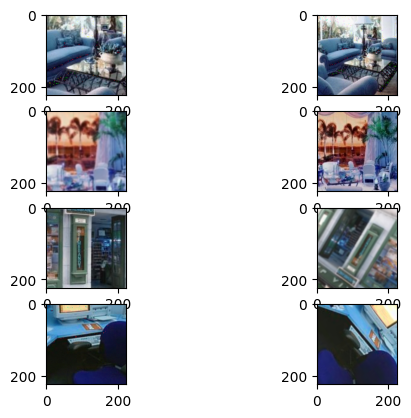

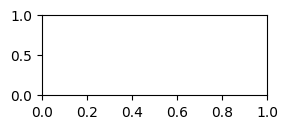

In [ ]:
plt.figure('train')
plt.subplot(421)
plt.imshow(train_sample[0][0, :].numpy())
plt.subplot(422)
plt.imshow(train_sample[1][0, :].numpy())

plt.subplot(423)
plt.imshow(train_sample[0][1, :].numpy())
plt.subplot(424)
plt.imshow(train_sample[1][1, :].numpy())

plt.subplot(425)
plt.imshow(train_sample[0][2, :].numpy())
plt.subplot(426)
plt.imshow(train_sample[1][2, :].numpy())

plt.subplot(427)
plt.imshow(train_sample[0][3, :].numpy())
plt.subplot(428)
plt.imshow(train_sample[1][3, :].numpy())

plt.figure('test')
plt.subplot(421)
plt.imshow(test_sample[0][0, :].numpy())
plt.subplot(422)
plt.imshow(test_sample[1][0, :].numpy())

plt.subplot(423)
plt.imshow(test_sample[0][1, :].numpy())
plt.subplot(424)
plt.imshow(test_sample[1][1, :].numpy())

plt.subplot(425)
plt.imshow(test_sample[0][2, :].numpy())
plt.subplot(426)
plt.imshow(test_sample[1][2, :].numpy())

plt.subplot(427)
plt.imshow(test_sample[0][3, :].numpy())
plt.subplot(428)
plt.imshow(test_sample[1][3, :].numpy())

In [ ]:
a = IM('release_test/testing/ADE_test_00000834.jpg')
a.shape

(707, 512, 3)

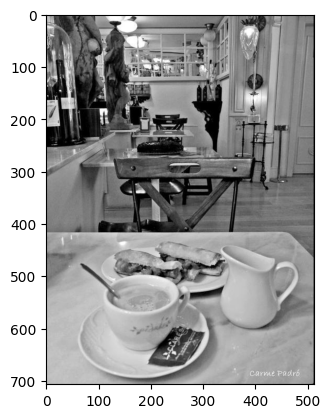

In [ ]:
plt.imshow(a)

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

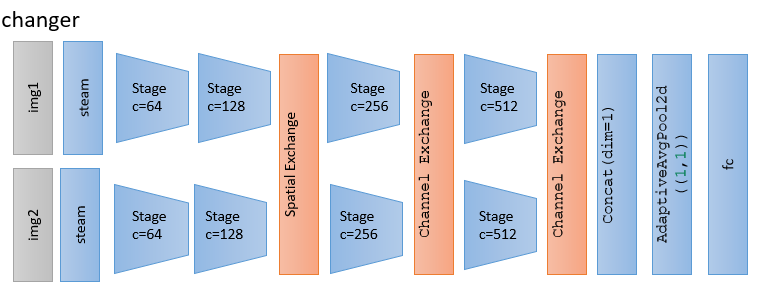

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


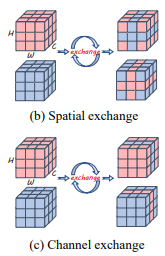

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

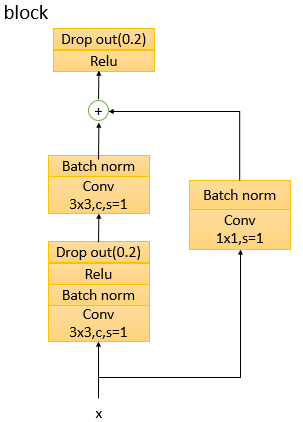

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [ ]:
##To Do
class block(nn.Module):
  def __init__(self,):
    super(block,self).__init__()
    self.conv1 = nn.Conv2d()

  def forward(self,x):


    return out

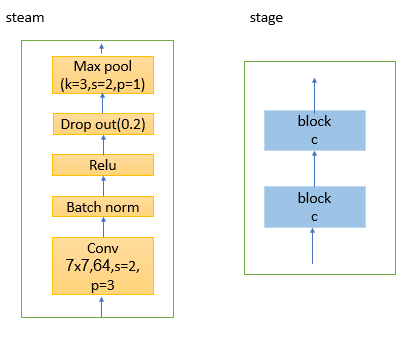

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(

        )

    self.stage1=
    self.stage2=
    self.stage3=
    self.stage4=





  def _make_stage(self,):

    layers=[]

    return nn.Sequential(*layers)




  def forward(self,x1,x2):



    return out

In [ ]:
## To Do
device =


model=changer(ResidualBlock,SpatialExchange,ChannelExchange).to(device)

citeration = ## loss
optimizer= ## optimizer

##Train & validation


In [ ]:

Loss_train=[]
Loss_val=[]


    print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')



#Test


In [ ]:
checkpoint = torch.load('#To Do')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test

print(f' loss_test= {:.3f}, acc_test={()}')


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟